In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
img = Image.open("./cat.tiff")
img_arr = np.array(img)

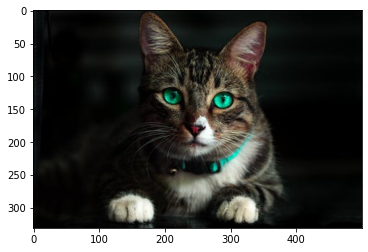

In [12]:
plt.imshow(img_arr);